# Single Gap BTK Fitting

<IPython.core.display.Javascript object>


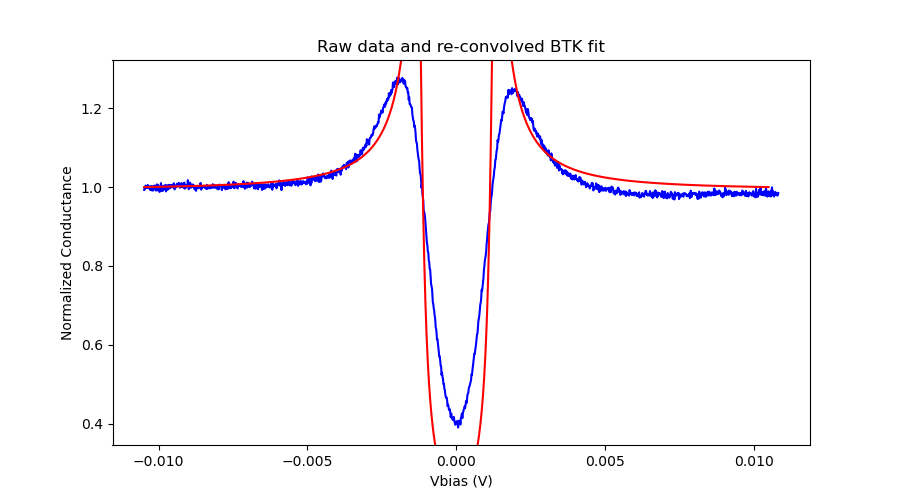

In [18]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
from scipy import optimize, signal, interpolate
import cmath, math
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, BoundedFloatText

#file path
fpath = "C:/Users/cliff_chen/Downloads/2020-04-28_dIdV_-700mV-700mV_forward sweep.txt"

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
ydata = data[:,-1] #select the y-data
xdata = data[:,0] #select the x-data
dlen = len(xdata)

#define fitting parameters
kb = 8.617333262*10**(-5)
lower_pbound = (0.00001, 0, 0) #Lower bounds on fitting parameters (g, d, z)
upper_pbound = (.02, .01, 15) #Upper bounds on fitting parameters (g, d, z)
t = 4.2   #Temperature
norm_len = 10 #number of points to use for normalization
direct = 1 #use left or right side of data for normalization, +1 for left side, -1 for right side
xstep = 10**-5 #xdata point spacing for uniform xdata

#define fitting functions
def gamma(x, g, d):
    return (abs(x) + g*1j - cmath.sqrt((abs(x) + g*1j)**2 - d**2)) / d

#Gamma function below assumes complex gap instead of real and broadening is caused by this imaginary part of the gap
#def gamma(x, g, d):
    #return (abs(x) - cmath.sqrt((abs(x))**2 - (d - 1j*g)**2)) / (d - 1j*g)

def tau(z):
    return 1 / (1 + z**2)

def conductance(x, g, d, z):
    return (1 + tau(z) * abs(gamma(x, g, d))**2 + (tau(z) - 1) * abs(gamma(x, g, d)**2)**2) / (abs(1 + (tau(z) - 1)*gamma(x, g, d)**2))**2

def conductance_arr(xarr, g, d, z):
    return np.array([conductance(x, g, d, z) for x in xarr])

def dfermi(x, t):
    if (abs(x) < .007):
        try:
            return math.exp(abs(x) / (kb * t)) / (kb * t * (1 + math.exp(abs(x) / (kb * t)))**2)
        except OverflowError as err:
            raise OverflowError('too large, adjust input limits')
    else:
        return 0

def dfermi_peak(xdata, t):
    return np.array([dfermi(x, t) for x in xdata])

def normalize(data):
    return np.divide(data, np.average(data[direct : direct*norm_len: direct]))

#check if xdata is not monotonic
for x in range(dlen - 1):
    if(xdata[x] > xdata[x + 1]):
        print(x)

#normalize conductance and determine data step size
ydata = normalize(ydata)

#bspline fitting for a smooth version of the data
#bspline will only be defined on the domain specified by the xdata, if the x values go out of bounds the function returns NaN
knots, coeff, order = interpolate.splrep(xdata, ydata, s = .04, k = 3)
spline = interpolate.BSpline(knots, coeff, order, extrapolate = False)

#create uniformly spaced xdata for the spline fitting
xlimit = min(abs(xdata[0]), abs(xdata[dlen - 1]))
uxdata= np.linspace(-math.floor(xlimit / xstep) * xstep, math.floor(xlimit / xstep) * xstep, num = 2 * math.floor(xlimit / xstep) + 1)
uxlen = len(uxdata)
pad_size = math.floor(uxlen / 2)

#Fermi derivative peak and bspline based on uniform xdata
bspline_ydata = np.array(spline(uxdata))

#functions to convolve fermi function with ydata
def thermal_broaden(data, t):
    global uxdata
    global pad_size
    padded = np.pad(data, (pad_size, pad_size), mode = 'edge')
    con = np.convolve(padded, dfermi_peak(uxdata, t), mode = 'valid')
    return normalize(con)

def broad_conductance(xarr, g, d, z):
    return thermal_broaden(conductance_arr(xarr, g, d, z), t)

#try fitting the convolved BTK conductance to the bspline ydata
popt, pcov = optimize.curve_fit(broad_conductance, uxdata, bspline_ydata, bounds = (lower_pbound, upper_pbound), method = 'trf')
g = popt[0]
d = popt[1]
z = popt[2]
fit_ydata = np.array([conductance(x, g, d, z) for x in uxdata])

#Create plots
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(xdata, ydata, color = 'blue')
fit_plt, = ax.plot(uxdata, thermal_broaden(fit_ydata, t), color='red')
ax.set_ylabel('Normalized Conductance')
ax.set_xlabel('Vbias (V)')
ax.title.set_text('Raw data and re-convolved BTK fit')

# widget setup
out = Output()

width = {'width': '500px'}
temp = FloatText(value = .3, description = 'Temp')
gamma_param = FloatSlider(value=g, min=10**-6, max=10**-3, step=10**-6, description = r'$\Gamma$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
barrier = FloatSlider(value=z, min=0.1, max=5, step=0.1, description = r'$Z$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap = FloatSlider(value=d, min=10**-4, max=2*10**-3, step=10**-4, description = r'$\Delta$', 
                         continuous_update = False, layout = width, readout_format = '.2e')


def update(temp, gamma_param, barrier, gap):
    global uxdata
    fit_plt.set_ydata(thermal_broaden(conductance_arr(uxdata, gamma_param, gap, barrier), temp))
    fig.canvas.draw_idle()

it = interactive(update, temp = temp, gamma_param = gamma_param, barrier = barrier, gap = gap)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')


vbox = VBox(children = (temp, gamma_param, barrier, gap, out), layout = box_layout)

display(vbox)

# Double BTK Fitting

<IPython.core.display.Javascript object>


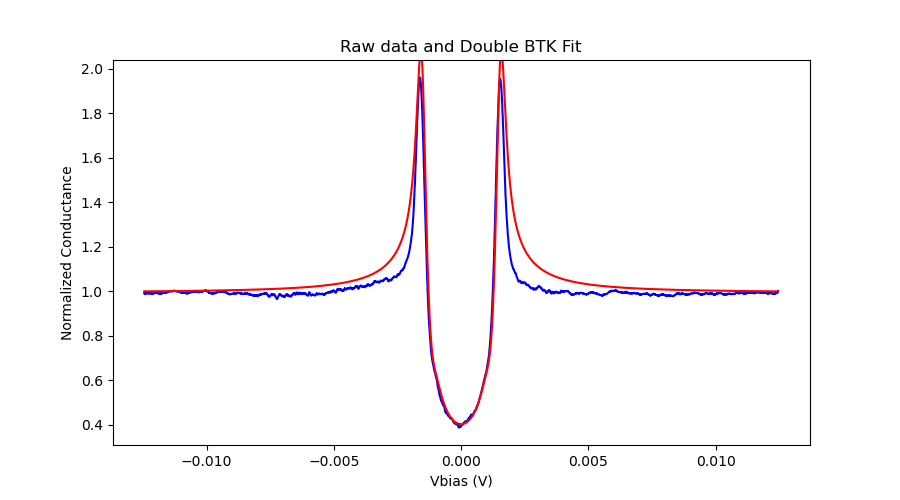

In [9]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
from scipy import optimize, signal, interpolate
import cmath, math
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, Button, Text
from ipywidgets import RadioButtons

#file path
fpath = "C:/Users/cliff_chen/Downloads/day 1 B 27 Oe.dat"

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float, skip_header = 1)
ydata = data[:,2] #select the y-data
xdata = data[:,1] #select the x-data
dlen = len(xdata)

# Scale/offset xdata
xdata = xdata/1000
xdata += .000084

#define fitting parameters
kb = 8.617333262*10**(-5)
lower_pbound = (0.00001, 0, 0) #Lower bounds on fitting parameters (g, d, z)
upper_pbound = (.02, .01, 15) #Upper bounds on fitting parameters (g, d, z)
t = 1   #Temperature
norm_len = 10 #number of points to use for normalization
direct = 1 #use left or right side of data for normalization, +1 for left side, -1 for right side
xstep = 10**-5 #xdata point spacing for uniform xdata

#define fitting functions
def gamma(x, g, d):
    return (abs(x) + g*1j - cmath.sqrt((abs(x) + g*1j)**2 - d**2)) / d

#Gamma function below assumes complex gap instead of real and broadening is caused by this imaginary part of the gap
#def gamma(x, g, d):
    #return (abs(x) - cmath.sqrt((abs(x))**2 - (d - 1j*g)**2)) / (d - 1j*g)

def tau(z):
    return 1 / (1 + z**2)

def conductance(x, g, d, z):
    return (1 + tau(z) * abs(gamma(x, g, d))**2 + (tau(z) - 1) * abs(gamma(x, g, d)**2)**2) / (abs(1 + (tau(z) - 1)*gamma(x, g, d)**2))**2

def conductance_arr(xarr, g, d, z):
    return np.array([conductance(x, g, d, z) for x in xarr])

def dfermi(x, t):
    if (abs(x) < .007):
        try:
            return math.exp(abs(x) / (kb * t)) / (kb * t * (1 + math.exp(abs(x) / (kb * t)))**2)
        except OverflowError as err:
            raise OverflowError('too large, adjust input limits')
    else:
        return 0

def dfermi_peak(xdata, t):
    return np.array([dfermi(x, t) for x in xdata])

def normalize(data):
    return np.divide(data, np.average(data[direct : direct*norm_len: direct]))

#normalize conductance and determine data step size
ydata = normalize(ydata)

#create uniformly spaced xdata for the spline fitting
xlimit = min(abs(xdata[0]), abs(xdata[dlen - 1]))
uxdata= np.linspace(-math.floor(xlimit / xstep) * xstep, math.floor(xlimit / xstep) * xstep, num = 2 * math.floor(xlimit / xstep) + 1)
uxlen = len(uxdata)
pad_size = math.floor(uxlen / 2)

#Fermi derivative peak

#functions to convolve fermi function with ydata
def thermal_broaden(data, t):
    global uxdata
    global pad_size
    padded = np.pad(data, (pad_size, pad_size), mode = 'edge')
    con = np.convolve(padded, dfermi_peak(uxdata, t), mode = 'valid')
    return normalize(con)

def broad_conductance(xarr, g, d, z):
    return thermal_broaden(conductance_arr(xarr, g, d, z), t)

# Default fitting

initial = thermal_broaden(0.5 * conductance_arr(uxdata, .0001, .001, 1) + 0.5 * conductance_arr(uxdata, .0001, .0005, 1), 0.3)

#Create plots
fig, ax = plt.subplots(figsize=(9,5))
origin, = ax.plot(xdata, ydata, color = 'blue')
fit_plt, = ax.plot(uxdata, initial, color='red')
ax.set_ylabel('Normalized Conductance')
ax.set_xlabel('Vbias (V)')
ax.title.set_text('Raw data and Double BTK Fit')

# widget setup
out = Output()

width = {'width': '700px'}
temp = FloatText(value = t, description = 'Temp')
gamma_param1 = FloatText(value = .0001, description = r'$\Gamma 1$')
barrier1 = FloatSlider(value=1, min=0.1, max=10, step=0.01, description = r'$Z1$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap1 = FloatSlider(value=.001, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta 1$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gamma_param2 = FloatText(value = .0001, description = r'$\Gamma 2$')
barrier2 = FloatSlider(value=1, min=0.1, max=10, step=0.01, description = r'$Z2$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap2 = FloatSlider(value=.0005, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta 2$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
weight = FloatSlider(value=0.5, min=0, max=1, step=.01, description = 'Weight', 
                         continuous_update = False, layout = width)

filetext = Text(value = 'C:/algos/jupyter-notebooks/data/',description = 'Filename', layout = width)

save = Button(description = 'Save')

save_option = RadioButtons(options=('Fit', 'Raw'))


def update(temp, gamma_param1, barrier1, gap1, gamma_param2, barrier2, gap2, weight):
    global uxdata
    fit_plt.set_ydata(thermal_broaden(weight*conductance_arr(uxdata, gamma_param1, gap1, barrier1) + (1-weight)*conductance_arr(uxdata, gamma_param2, gap2, barrier2), temp))
    fig.canvas.draw_idle()
    
def buttonClick(b):
    if(save_option.value is 'Fit'):
        np.savetxt(filetext.value, np.vstack((uxdata, np.array(fit_plt.get_ydata()))).T, delimiter = '\t', fmt = '%.4e')
    else:
         np.savetxt(filetext.value, np.vstack((xdata, ydata)).T, delimiter = '\t', fmt = '%.4e')
    
save.on_click(buttonClick)

it = interactive(update, temp = temp, gamma_param1 = gamma_param1, barrier1 = barrier1, gap1 = gap1,
                gamma_param2 = gamma_param2, barrier2 = barrier2, gap2 = gap2, weight = weight)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')

hbox = HBox(children = (save, save_option))

vbox = VBox(children = (temp, gamma_param1, barrier1, gap1, gamma_param2, barrier2, gap2, weight, filetext, hbox), layout = box_layout)

display(vbox)

# Fermi Liquid Effects in high field tunneling

[paper here](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.31.5811)

Weak coupling theory in superconductors involves several small expansion parameters:

1. Tc / $\theta_{debye}$
2. 1 / $k_f l$ = disorder parameter
3. 1 / $k_f \xi_0$
4. N(0)V, N(0) = DOS in normal state, V = interaction potential strength

Weak coupling theory is exact to 1st order in these parameters. Including these parameters to higher order results in different theories used to explain different effects:

1. Corrections to Tc / $\theta_{debye}$ are called strong-coupling effects
2. Corrections to 1 / $k_f l$ describe weak localization effects
3. Corrections to 1 / $k_f \xi_0$ are found in superfluid He3

Weak-coupling theory often ignores 3 additional effects:

1. Fermi-liquid effects - This renormalizes and adjusts certain parameters like density of states, Fermi velocities, mass, etc. 
2. Anisotropy effects - The fact that the Fermi surface is not a sphere and not isotropic. 
3. Impurity scattering

Some background information regarding Fermi liquid effects and theory:
The theory starts with a non-interacting Hamiltonian and turning on the interaction slowly in an adiabatic way. By doing it this way, Landau argues that the excited states of the original non-interacting case will smoothly transform into the excited states of the interacting system. This implies a bijection between the states of the non-interacting case and the interacting case. 

However, the excited states that are given by this bijection are not true eigenstates of the interacting Hamiltonian and, as such, they are not stationary. Therefore, there is a life-time associated with these excitations. These excitation in turn are called quasi-particles. They are called this way because the original particles, of the non-interacting system, become 'dressed' by the interactions so that certain dynamic properties of the particles, such as mass, are renormalized to new values. 

The act of turning on the interaction involves working with a time scale $\tau$ that must be bounded between two values. First, it must smaller than the energy scaled of interest $\epsilon$ so $\epsilon > \hbar / \tau$ or $\tau > \hbar / \epsilon$. Second, it must be smaller than the life-time of the quasi-particle otherwise the quasi-particle will disappear. 


Since we assume dirty limit, we take $l / \xi_0 \approx l / (\hbar v_f / k_b T_c) << 1$ with $l$ being the mean free path and $\xi_0$ being the coherence length. 

# Heat / Intensity Map Plotting

In [ ]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, Button, Text
from ipywidgets import RadioButtons

#file path
fpath = "C:/Users/cliff_chen/Downloads/2021-04-23_dIdV_vary H persistent_-8T - 0T_0.25T dT_12nm Nb_5nmAu_300mK_smoothed_unnormalized_all plots.txt"

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
print('Num data pts = {0}, Num Plots = {1}'.format(data.shape[0], data.shape[1] // 2))

#since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
xlimits = (-.0017, .0017)
xscale = 1000 #to multiply the x-coordinates
yscale = 1 #to multiply the y-coordinates

param_values = np.linspace(-8, 0, num=33)

num_plots = data.shape[1] // 2
x = []
z = []

for i in range(num_plots):
    z.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2+1])
    x.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2])
    
z = np.concatenate(z)
x = xscale * np.concatenate(x)

#repeat param_values array and then resahpe to get the Y-coord grid, similar to what one would get from meshgrid
y = np.repeat(param_values, x.shape[1], axis = 0)
y = yscale * np.reshape(y, (len(param_values), x.shape[1]))

#normalize data
for i in range(num_plots):
    z[i, :] *= 1 / np.average(data[0:5, i*2 + 1])

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(x,y,z, vmin = 0, vmax = 1.2, shading = 'gouraud')
ax.set_xlabel('Vbias (meV)')
ax.set_ylabel('Magnetic Field (T)')

cbar = plt.colorbar(pmesh, orientation = 'vertical')
cbar.set_label('Normalized Conductance')

plt.show()

#plt.savefig('./img/2021-04-23_dIdV ptcontact_300K_-8T - 0T inplane.png')

# General Plotting

<IPython.core.display.Javascript object>


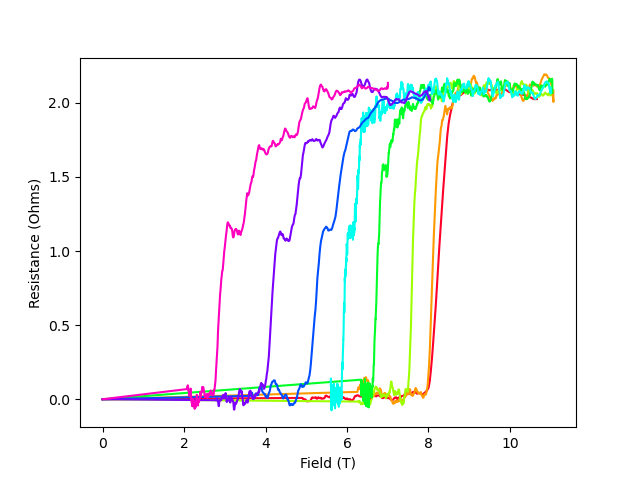

In [8]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, Button, Text
from ipywidgets import RadioButtons

#single file path
fpath = "C:/Users/cliff_chen/Downloads/2021-04-23_R vs T_const current_411.6nA_12nm Nb_5nmAu_4term_0T-7T_smoothed.txt"

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
dim = data.shape

#pick plot number
plot_num = -1
x_scale = 1000

#build rainbow cmap for legend
plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, int(dim[1] / 2)))

fig, ax = plt.subplots()

if plot_num < 0:
    for i in range(int(dim[1] / 2)):
        ax.plot(data[:, 2*i], data[:, 2*i + 1], color = plot_cm[i])
else:
    ax.plot(data[:, plot_num*2] * x_scale, data[:, 2*plot_num+1] / np.average(data[0:5, 2*plot_num+1]), color='blue')

ax.set_xlabel('Field (T)')
ax.set_ylabel('Resistance (Ohms)')

plt.show()

#plt.savefig('./img/2021-04-23_dIdV ptcontact_300mK_-8T - 0T inplane_1T plot.png')

# Multiple File Plotting

<IPython.core.display.Javascript object>


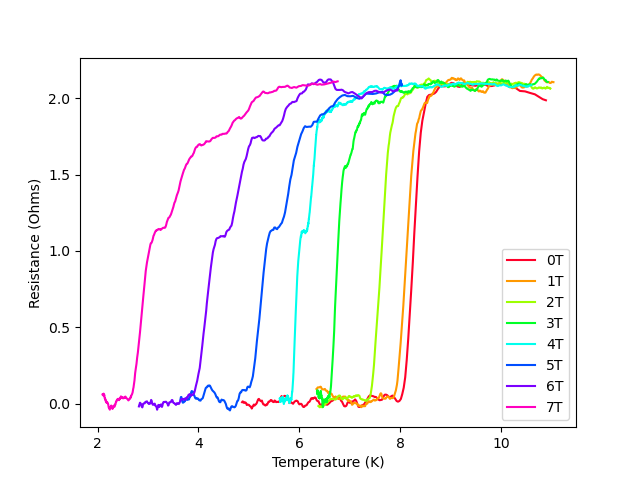

In [8]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, glob, os
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, Button, Text
from ipywidgets import RadioButtons

#directory
data_dir = "C:/Users/cliff_chen/Downloads/2021-04-23_transport"

#load data
data = []
os.chdir(data_dir)
files = glob.glob('*[0-9]T.txt')

for file in files:
    data.append(np.genfromtxt(file, delimiter="\t", dtype=float))

num_plots = len(data)


#build rainbow cmap for legend
plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, num_plots))

fig, ax = plt.subplots()

for i in range(num_plots):
    ax.plot(data[i][:, 0], data[i][:, 1], color = plot_cm[i])

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Resistance (Ohms)')
ax.legend(['0T','1T', '2T', '3T', '4T', '5T', '6T', '7T'])

plt.show()

#save img
os.chdir('C:/algos/jupyter-notebooks')
plt.savefig('./img/2021-04-23_RvsT_12nm Nb_5nm Au_0T-7T.png')

# H - T Pauli Limit Fit

[3.05508357]


<IPython.core.display.Javascript object>


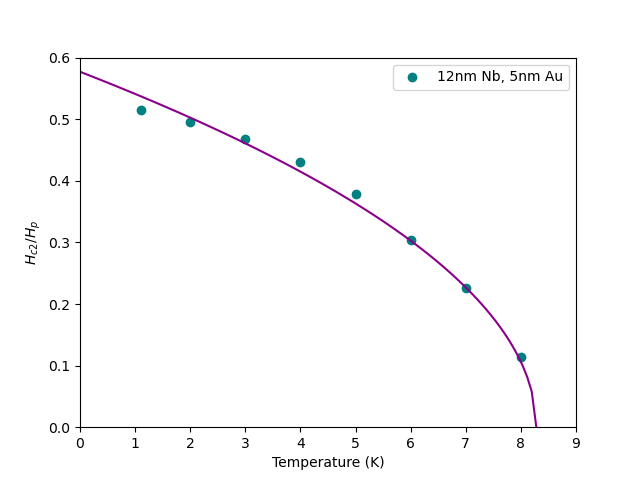

In [9]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, Button, Text
from ipywidgets import RadioButtons

#file path
fpath = "C:/Users/cliff_chen/Downloads/2021-04-23_transport/2021-04-23_RvsH_H-T diagram.txt"

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
fields = data[:, 1]
temps = data[:, 0]

#pair breaker function
def get_pair_breaker(tc0):
    return lambda arr, a: np.array([a*math.sqrt(tc0 - x) for x in arr])

#zero field transition temp
tc0 = 8.28
pauli_limit = 1.84*tc0

#fit the data
pair_break = get_pair_breaker(tc0)
amplitude = optimize.curve_fit(pair_break, temps, fields, (1))[0]
print(amplitude)

#plot the data
lin_temps = np.linspace(0, tc0, 101)

fig, ax = plt.subplots()
ax.scatter(temps, fields / pauli_limit, c = 'teal', label = '12nm Nb, 5nm Au')
ax.plot(lin_temps, [amplitude*math.sqrt(tc0 - x) / pauli_limit for x in lin_temps], color = 'darkmagenta')
ax.set_ylim((0, 0.6))
ax.set_xlim((0, math.ceil(tc0)))
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$H_{c2} / H_p$')
ax.legend()
plt.show()

#plt.savefig('./img/2021-04-23_H-T diagram_RvsH.png')

# Step function mid point fit

[ 1.84714901  7.55498746 -0.63663243]


<IPython.core.display.Javascript object>


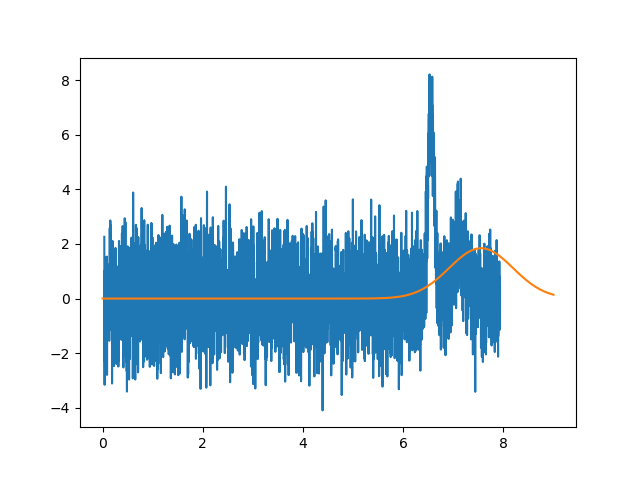

In [7]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, Button, Text
from ipywidgets import RadioButtons

#file path
fpath = "C:/Users/cliff_chen/Downloads/2021-04-23_transport/2021-04-23_RvsH_const curr 274.4nA_12nm Nb_5nm Au_inplane_4K.txt"

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
ydata = data[:, 1]
xdata = data[:, 0]

#gaussian function
def gaussian(arr, a, b, c):
    return np.array([a*math.exp(-(x-b)**2 / (2*c**2)) for x in arr])

dx = np.diff(xdata)
dy = np.diff(ydata)
deriv = dy / dx

gauss_params, pcov = optimize.curve_fit(gaussian, xdata, ydata, (5, 5, 1))
print(gauss_params)
lin_xdata = np.linspace(0, 9, 101)

fig, ax = plt.subplots()

ax.plot(xdata[0: len(xdata) - 1], deriv)
ax.plot(lin_xdata, gaussian(lin_xdata, *gauss_params))

plt.show()